## ETF Rotation

### 背景

某天在雪球看到了 [最高14年278倍而且适合不同风险偏好的简单策略——股债轮动（十七）](https://xueqiu.com/1884493065/127183820) 的系列文章，觉得数据有点夸张。

然后查阅了相关资料，如下：

- [蛋卷斗牛二八轮动(DJ:CSI001)](https://xueqiu.com/S/CSI001)
- [蛋卷斗牛二八轮动Plus(DJ:CSI010)](https://xueqiu.com/S/CSI010)
- [ETF Rotation Systems to beat the Market - American Equities](http://www.the-lazy-trader.com/2015/01/etf-rotation-systems-to-beat-market-American-Equities.html)
- [ETF Momentum Rotation Systems - 2017 Results](http://www.the-lazy-trader.com/2018/01/etf-momentum-rotation-systems-2017-results.html)

### 简介

ETF Rotation（ETF轮动）策略，本质上是一种趋势/动量跟踪策略。

牛市追踪强者，熊市退出避险，震荡市被反复打脸。

### 标的

趋势跟踪的关键是长期复利。

A股每几年就来一次疯牛疯熊，长期持有等于坐过山车，而趋势跟踪能吃到倍数复利。

前提是，能长期活下去。

一旦归零，就永无翻身了。

因此轮动策略最好的标的是宽基指数/ETF，即

- 沪深300
- 中证500
- 上证50
- 中证1000
- 中小板
- 创业板

等等...

### 相关系数

既然涉及到轮动，那么标的之间应该具备差异性。

假设极端情况一，各个标的之间的涨跌是完全一致的，那么轮动并没有任何效果，和单一标的没有任何区别。

假设极端情况二，存在两个标的的涨跌是完全相反的，例如买多、买空，那么轮动理论上能达到最大效益。

我们本次简单处理，简单操作，只考虑买多的情况，因此，各个标的之间应该尽量不相关。



In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
try:
    import empyrical as emp
except:
    emp = None
import tushare as ts
import time
import random
# from concurrent.futures import ProcessPoolExecutor

from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq
from spider.spider_coinmarketcap import Spider_coinmarketcap

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

CONF = Config('../conf/secret.yaml').data[0]
ts_token = CONF['TUSHARE']['TOKEN']
ts.set_token(ts_token)
pro = ts.pro_api()

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
CRYPTOCURRENCY = list(CRYPTOCURRENCY.keys())
NASDAQ100 = CONF['NASDAQ100']

BENCHMARK = '399300'
# BENCHMARK = 'BITCOIN'
ROTATION_LIST = ['399300', '000016', '000905', '399006', '000012']
# ROTATION_LIST = ['399300', '000905', '399006', '000012']
# ROTATION_LIST = ['399300', '000905', '399006', '000012']
# ROTATION_LIST = ['399300', '000905', '000016']
# ROTATION_LIST = ['BITCOIN', 'EOS', 'TETHER']
# ROTATION_LIST = ['510300', '510500', '510050', '159915', '000012']

pd

<module 'pandas' from 'd:\\python3\\lib\\site-packages\\pandas\\__init__.py'>

In [8]:
%%time

### 时间设置
start_date = '2015-01-01'
end_date = '2019-05-01'
end_date = time.strftime('%Y-%m-%d')

POS = 1

### ETF Rotation System
N = 17
M = 20
K = 5

### 业务设置
START_MONEY = 100000
PROPERTY = START_MONEY
CASH = START_MONEY


Wall time: 0 ns


In [3]:
%%time

IS_DOWNLOAD_DATA = False

spider_n = Spider_nasdaq()
spider_c = Spider_coinmarketcap()

for symbol in ROTATION_LIST + [BENCHMARK]:
    if not IS_DOWNLOAD_DATA:
        break
        
    print(symbol)

    # 指数
    if symbol in ['399300', '000905', '000016', '399006', '000012', '000852']:
        df = ts.get_k_data(code=symbol, index=True, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
    
    # CRYPTOCURRENCY
    elif symbol in CRYPTOCURRENCY:
        datafile = spider_c.get_coin_data(symbol, start_date='20100101', end_date=time.strftime('%Y%m%d'))
        print(datafile)
        
    # ETF
    else:
        df = ts.get_k_data(code=symbol, ktype='D', autype='qfq', index=False, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
        time.sleep(1)
        
#     print(datafile)
    time.sleep(1)

Wall time: 0 ns


In [4]:
%%time

stock_df_dict = {}

for symbol in ROTATION_LIST + [BENCHMARK]:
    stock_data_file = '../database/market/%s.csv' % symbol
    try:
        stock_df = pd.read_csv(stock_data_file)
    except:
        print(symbol)
        continue

    # 筛选字段
    stock_df = stock_df.loc[:, ['date', 'open', 'close']]
    
    # 特殊处理，用当天收盘价做判定和交易
#     stock_df['open'] = stock_df['close']

    # 去掉Nasdaq行情首行的当天行情
    if symbol in NASDAQ100:
        stock_df = stock_df.drop([0])

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期
    # 445 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    stock_df = stock_df.assign(date=pd.to_datetime(stock_df['date']))  # need .index.to_period('D')

    # 用日期作索引，日期升序排序
    # 95.1 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
    if symbol in NASDAQ100 or symbol in CRYPTOCURRENCY:
        stock_df = stock_df[::-1]
    stock_df.set_index(['date'], inplace=True)
    stock_df.index = stock_df.index.to_period('D')

    # 计算每天涨跌幅
#     stock_df['o_pct_chg'] = stock_df.open.pct_change(1)
#     stock_df['c_pct_chg'] = stock_df.close.pct_change(1)
#     stock_df['c_o_pct_chg'] = (stock_df.open - stock_df.close.shift(1)) / stock_df.close.shift(1)
#     stock_df['N_chg'] = stock_df.open.pct_change(N)
    # 特殊处理，用昨天收盘价做判定
#     stock_df['N_chg'] = (stock_df.close.shift(1) - stock_df.close.shift(N)) / stock_df.close.shift(N)
#     stock_df['N_sht'] = stock_df.open.shift(N)
#     stock_df['N_chn'] = stock_df.open.shift(N) - stock_df.open
    
    # MA均线指标
#     stock_df['MA%d' % M] = stock_df['open'].rolling(M).mean()
    
    # 减少数据
    stock_df.dropna(how='any', inplace=True)
    
    stock_df_dict[symbol] = stock_df

Wall time: 79 ms


In [5]:
# stock_df_dict['399300']['500_c_pct_chg'] = stock_df_dict['000905']['c_pct_chg']
# stock_df_dict['399300']['500_close'] = stock_df_dict['000905']['close']

# df = stock_df_dict['399300'].dropna(how='any', inplace=False).copy()

# show_columns = ['c_pct_chg', '500_c_pct_chg']
# show_columns = ['close', '500_close']
# df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
# df['500_close'] = (df['500_close'] - df.iloc[0]['500_close']) / df.iloc[0]['500_close']
# df = df.loc[:, show_columns]
# # # df = df.iloc[-100:]
# df.reset_index(drop=False, inplace=True)
# df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
# df.set_index(keys=['date'], inplace=True)

# # display_charts(df, chart_type='stock', kind='line', figsize=(900, 600), logy=False)

Index(['300_close', '500_close', '50_close', 'cyb_close'], dtype='object')

,300_close,500_close,50_close,cyb_close
300_close,1.000000,0.646517,0.975588,0.732413
500_close,0.646517,1.000000,0.459932,0.930946
50_close,0.975588,0.459932,1.000000,0.660401
cyb_close,0.732413,0.930946,0.660401,1.000000


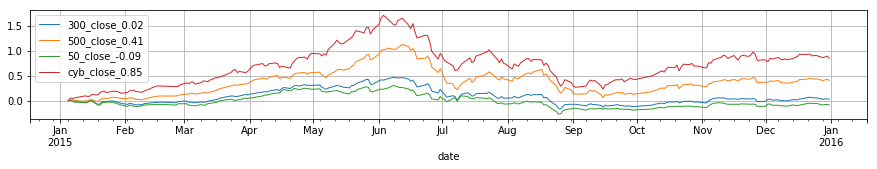

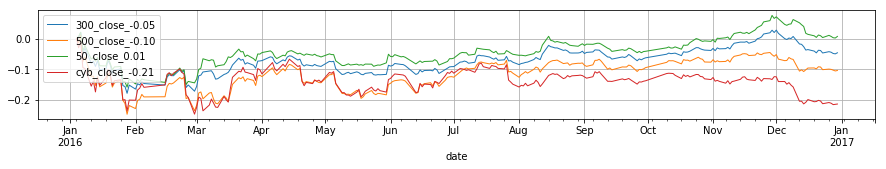

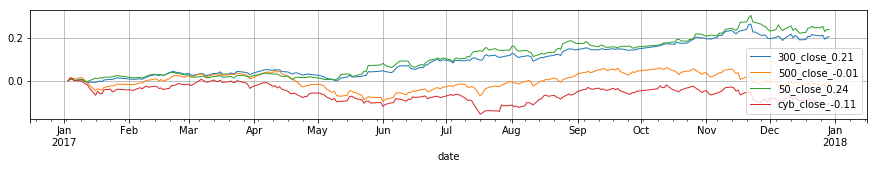

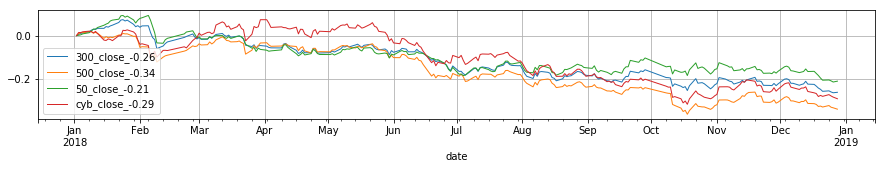

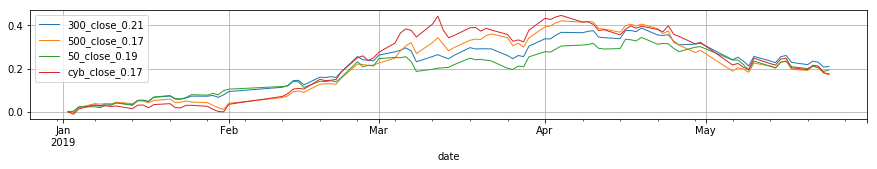

In [9]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 2]

show_df = stock_df_dict['399300'].copy()

show_df['300_close'] = show_df['close']
show_df['500_close'] = stock_df_dict['000905']['close']
show_df['50_close'] = stock_df_dict['000016']['close']
show_df['cyb_close'] = stock_df_dict['399006']['close']
show_df.drop(columns=['open', 'close'], inplace=True)
show_df.columns

# show_df['300_close'].corr(show_df['500_close'])
show_df.corr()

for y in range(int(start_date.split('-')[0]), int(end_date.split('-')[0]) + 1, 1):
    df = show_df.dropna(how='any', inplace=False).copy()
    df = df.loc['%d-01-01' % y:'%d-01-01' % (y + 1)]
    df = df.dropna(how='any', inplace=False)
#     df.drop(columns=['close'], inplace=True)
#     df['300_close'] = (df['300_close'] - df.iloc[0]['300_close']) / df.iloc[0]['300_close']
#     df['500_close'] = (df['500_close'] - df.iloc[0]['500_close']) / df.iloc[0]['500_close']
    ax = None
#     ax = df.plot(kind='line', y='close', title='%d-%d' % (y, y + 1), label='BENCHMARK_%.2f' % df.iloc[-1]['close'], linewidth=1, grid=True)
    for col in sorted(df.columns):
        if 'close' in col:
            df[col] = (df[col] - df.iloc[0][col]) / df.iloc[0][col]
            ax = df.plot(kind='line', y=col, secondary_y=False, label='%s_%.2f' % (col, df.iloc[-1][col]), linewidth=1, grid=True, ax=ax)

In [ ]:
try:
except

In [ ]:
'''用基准数据来存储策略数据'''
show_df = None
show_df = stock_df_dict[BENCHMARK].copy()
show_df.loc[:, 'CASH'] = START_MONEY
show_df.loc[:, 'PROPERTY'] = START_MONEY

In [ ]:
%%time
# %xmode

'''ETF轮动策略，持有N天涨幅最高的标的，若涨幅全为负，则持债/货币基金。'''

PROPERTY = START_MONEY
CASH = START_MONEY
count_day = 0
yesterday = None

order_df = None
order_df = pd.DataFrame(columns=[
    'buy_date', 'symbol', 'buy_count', 'buy_price', 'buy_reason', 'sell_date', 'sell_price', 'sell_reason', 'profit', 'cash', 'property'
])

ops_df = None
ops_df = pd.DataFrame(columns=[
    'ops_date', 'ops', 'symbol', 'count', 'price', 'reason', 'profit'
])

df_start_day = stock_df_dict[BENCHMARK].head(1).index[0].strftime('%Y-%m-%d')
if df_start_day > start_date:
    run_start_day = df_start_day
else:
    run_start_day = start_date

# 时间序列
for today in pd.period_range(start=run_start_day, end=end_date, freq='D'):
    count_day += 1
    is_change = True
    
    # 每年年初计算回报率
    if today.dayofyear == 1 or today == (pd.to_datetime(end_date)).to_period(freq='D'):
        if today.dayofyear == 1:
            lastyear_firstday = pd.to_datetime('%d-01-01' % (today.year - 1))
        else:
            lastyear_firstday = pd.to_datetime('%d-01-01' % today.year)
        lastyear_firstday = lastyear_firstday.to_period(freq='D')
#         print(today, show_df.iloc[0].name, show_df[:today].iloc[-1].PROPERTY)
        if today > show_df.iloc[0].name:
            today_property = show_df[:today].iloc[-2].PROPERTY
            today_bencnmark_property = stock_df_dict[BENCHMARK][:today].iloc[-2].open
#             print(show_df[:today].iloc[-1])
        else:
            today_property = show_df.iloc[0].PROPERTY
            today_bencnmark_property = stock_df_dict[BENCHMARK].iloc[0].open
        if lastyear_firstday > show_df.iloc[0].name:
            lastyear_firstday_property = show_df[:lastyear_firstday].iloc[-1].PROPERTY
            lastyear_firstday_benchmark_property = stock_df_dict[BENCHMARK][:lastyear_firstday].iloc[-1].open
        else:
            lastyear_firstday_property = show_df.iloc[0].PROPERTY
            lastyear_firstday_benchmark_property = stock_df_dict[BENCHMARK].iloc[0].open
#         lastyear_return = round((today_property - lastyear_firstday_property) / lastyear_firstday_property, 4)
        lastyear_return = '%.3f' % ((today_property - lastyear_firstday_property) / lastyear_firstday_property)
        lastyear_benchmark_return = '%.3f' % (
            (today_bencnmark_property - lastyear_firstday_benchmark_property) / lastyear_firstday_benchmark_property
        )
        print(lastyear_firstday, today, '\t|', 
              int(lastyear_firstday_benchmark_property), int(today_bencnmark_property), lastyear_benchmark_return, '\t|', 
              int(lastyear_firstday_property), int(today_property), lastyear_return)
        
    
    if yesterday is None:
        yesterday = today
        continue

    # 日期不在基准交易日，则不交易
    if today not in stock_df_dict[BENCHMARK].index:
        continue
    
#     benchmark_today_market = stock_df_dict[BENCHMARK].loc[today]
    
    # 计算标的今天的N天涨跌幅，找到买入目标
#     N_chg_list = []
#     for symbol in ROTATION_LIST:
#         # 部分标的早期不存在
#         if today not in stock_df_dict[symbol].index:
#             N_chg_list.append(-999)
#         elif symbol == '000012':
#             N_chg_list.append(-999)
#         else:
#             today_market = stock_df_dict[symbol].loc[today]
#             N_chg_list.append(today_market.N_chg)
#     max_N_chg = max(N_chg_list)
#     target_symbol = ROTATION_LIST[N_chg_list.index(max_N_chg)]
#     if max_N_chg < 0:
#         target_symbol = '000012'
        
    
    N_chg_list = []
    for symbol in ROTATION_LIST:
        # 部分标的早期不存在
        if today not in stock_df_dict[symbol].index:
            N_chg_list.append(-999)
        else:
            today_market = stock_df_dict[symbol].loc[today]
            N_chg_list.append(today_market.N_chg)
    max_N_chg = max(N_chg_list)
    target_symbol = ROTATION_LIST[N_chg_list.index(max_N_chg)]
    
    
#     # 计算标的今天的N天涨跌幅，找到买入目标
#     N_chg_list = []
#     for symbol in ROTATION_LIST:
#         # 部分标的早期不存在
#         if today not in stock_df_dict[symbol].index:
#             N_chg_list.append(-999)
#         elif symbol == '000012':
#             N_chg_list.append(-999)
#         else:
#             today_market = stock_df_dict[symbol].loc[today]
#             N_chg_list.append(today_market.N_chg)
#     max_N_chg = max(N_chg_list)
#     target_symbol = ROTATION_LIST[N_chg_list.index(max_N_chg)]
#     today_market = stock_df_dict[target_symbol].loc[today]
#     if today_market.open < today_market['MA%d' % M]:
#         target_symbol = '000012'
    
    
    # 判断当前持有标的，和买入目标，是否相同，相同则今天不交易
    cur_order = None
    if len(order_df[(order_df['buy_count'] > 0) & (order_df['sell_price'] == 0)]) != 0:
        cur_order = order_df[(order_df['buy_count'] > 0) & (order_df['sell_price'] == 0)].iloc[-1]
        holding_symbol = cur_order.symbol
    else:
        holding_symbol = ''
        is_change = True
    if target_symbol == holding_symbol:
        is_change = False
    if cur_order is not None and today - cur_order.buy_date < K:
        is_change = False
    if holding_symbol != '' and today not in stock_df_dict[holding_symbol].index:
        is_change = False
    if today not in stock_df_dict[target_symbol].index:
        is_change = False
    
    # 当前持有标的和买入目标不相同，或者今天是首日空仓，则今天交易，换仓/全仓
    if is_change and holding_symbol != '':
        today_market = stock_df_dict[holding_symbol].loc[today]
        # 停牌了/数据出错了，今天卖不了了，完了
        if today not in stock_df_dict[holding_symbol].index:
            continue
        # 跌停板，卖不掉，其实基本不可能，因为是指数ETF轮动
        if today_market.c_o_pct_chg < -0.1 and False:
            print(today, holding_symbol, '跌停板，卖不掉')
            continue
        CASH += cur_order.buy_count * today_market.open
        idx = cur_order.name
        order_df.loc[idx, 'sell_date'] = today
        order_df.loc[idx, 'sell_price'] = today_market.open
        order_df.loc[idx, 'sell_reason'] = 'EXIT'
        order_df.loc[idx, 'profit'] = (today_market.open - cur_order.buy_price) * cur_order.buy_count
#         print(today, '退出', stock_df_dict[symbol].loc[today, 'open'], CASH)
                
        ops_df = ops_df.append(
            {
                'ops_date': today,
                'ops': 'SELL',
                'symbol': holding_symbol,
                'count': cur_order.buy_count,
                'price': today_market.open,
                'reason': cur_order.buy_reason,
                'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
            },
            ignore_index=True
        )
    
    if is_change:
        # 开始执行买入
        today_market = stock_df_dict[target_symbol].loc[today]

        # 停牌了/数据出错了，今天卖不了了，完了
        if today not in stock_df_dict[target_symbol].index:
            continue
            
        buy_price = today_market.open
        buy_count = int(CASH / buy_price)
        buy_reason = 'CHANGE'

        # 涨停板，买不进，其实基本不可能，因为是指数ETF轮动
        if today_market.c_o_pct_chg > 0.1:
            print(today, target_symbol, '涨停板，买不进')
            buy_count = 0

        if buy_count > 0:
            CASH -= buy_count * buy_price
            order_df = order_df.append(
                {
                    'buy_date': today,
                    'symbol': target_symbol,
                    'buy_count': buy_count,
                    'buy_price': today_market.open,
                    'buy_reason': buy_reason,
                    'sell_date': pd.np.nan,
                    'sell_price': 0,
                    'profit': 0,
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
            ops_df = ops_df.append(
                {
                    'ops_date': today,
                    'ops': 'BUY',
                    'symbol': target_symbol,
                    'count': buy_count,
                    'price': buy_price,
                    'reason': buy_reason,
                    'profit': 0,
                },
                ignore_index=True
            )
            
    # 每天盘点财产
    show_df.loc[today, 'CASH'] = CASH
    PROPERTY = CASH + \
        sum(
            [
                stock_df_dict[order_df.loc[idx, 'symbol']][:today].iloc[-1].open * order_df.loc[idx, 'buy_count'] \
                for idx in order_df.loc[order_df['sell_price']==0].index
            ]
        )
    show_df.loc[today, 'PROPERTY'] = PROPERTY

    
# 最后一天，清仓
order_arr = order_df.to_records(index=False)
for idx in order_df[order_df['sell_price'] == 0].index:
    cur_order = order_df.loc[idx]
    symbol = cur_order['symbol']
    today_market = stock_df_dict[symbol][:today].iloc[-1]
    CASH += cur_order.buy_count * today_market.open
    order_df.loc[idx, 'sell_date'] = today
    order_df.loc[idx, 'sell_price'] = today_market.open
    order_df.loc[idx, 'sell_reason'] = 'EXIT'
    order_df.loc[idx, 'profit'] = \
        (today_market.open - cur_order.buy_price) * cur_order.buy_count
    ops_df = ops_df.append(
        {
            'ops_date': today,
            'ops': 'SELL',
            'symbol': symbol,
            'count': cur_order.buy_count,
            'price': today_market.open,
            'reason': cur_order.buy_reason,
            'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
        },
        ignore_index=True
    )


print('START_MONEY', START_MONEY)
print('CASH', CASH)
print('PROPERTY', PROPERTY)

s_p = stock_df_dict[BENCHMARK][start_date:].iloc[0].open
e_p = stock_df_dict[BENCHMARK][:end_date].iloc[-1].open
print('BENCHMARK', s_p, e_p, e_p / s_p)

show_df['PROPERTY_ER'] = show_df['PROPERTY']

In [ ]:
order_df
# ops_df

In [ ]:
df = show_df.dropna(how='any', inplace=False).copy()
df = df.loc[start_date:end_date]
algo = df['PROPERTY'].pct_change()
benchmark = df.open.pct_change()

DAYS_ALL = len(df)
DAYS_NOFULLHOLD = len(df[df['CASH'] > (df['PROPERTY'] / POS)])

output_str = ''

df = order_df.copy()
df['pro_pct'] = (df.sell_price - df.buy_price) / df.buy_price
df = df.loc[:, ['symbol', 'pro_pct']]
df = df.groupby(by='symbol').sum()
buy_stock_count = len(df)

score_sr = pd.Series({
    'START': start_date,
    'END': end_date,
    'POS': POS,
    'N': N,
    'M': M,
    'K': K,
    'ORDER': len(order_df),
    'STOCK': buy_stock_count,
    'RETURN_ALGO': emp.cum_returns(algo)[-1],
    'RETURN_BENC': emp.cum_returns(benchmark)[-1],
    'MAXDROPDOWN_ALGO': emp.max_drawdown(algo),
    'MAXDROPDOWN_BENC': emp.max_drawdown(benchmark),
    'WINRATE_ORDER': len(order_df[order_df.profit > 0]) / len(order_df[order_df.profit != 0]),
    'WINRATE_YEARLY': 0,
    'ANNUAL_RETURN': emp.annual_return(algo),
    'ANNUAL_VOLATILITY': emp.annual_volatility(algo, period='daily'),
    'CALMAR_RATIO': emp.calmar_ratio(algo),
    'SHARPE_RATIO': emp.sharpe_ratio(returns=algo),
    'ALPHA': emp.alpha(returns=algo, factor_returns=benchmark, risk_free=0.00),
    'BETA': emp.beta(returns=algo, factor_returns=benchmark, risk_free=0.00),
    'DAYS_ALL': DAYS_ALL,
    'DAYS_NOFULLHOLD': DAYS_NOFULLHOLD,
    'RET_PER_YEAR': output_str,
})

YEAR_COUNT = 0
ALGO_WIN_YEAR_COUNT = 0
df = show_df.dropna(how='any', inplace=False).copy()
df = df.loc[start_date:end_date]
for y in range(int(start_date.split('-')[0]), int(end_date.split('-')[0]) + 1, 1):
    y_df = df.loc['%d-01-01' % y:'%d-01-01' % (y + 1)]
    # info('y = %d' % y)
    if len(y_df) == 0:
        continue
    y_algo = y_df['PROPERTY'].pct_change()
    y_benchmark = y_df.open.pct_change()
    score_sr['RETURN_ALGO_%d' % y] = emp.cum_returns(y_algo)[-1]
    score_sr['RETURN_BENC_%d' % y] = emp.cum_returns(y_benchmark)[-1]
    YEAR_COUNT += 1
    if score_sr['RETURN_ALGO_%d' % y] > score_sr['RETURN_BENC_%d' % y]:
        ALGO_WIN_YEAR_COUNT += 1

score_sr['WINRATE_YEARLY'] = ALGO_WIN_YEAR_COUNT / YEAR_COUNT

score_sr

In [ ]:
'''计算标的持有、收益等'''

df = order_df.copy()
df.drop(columns=['sell_reason', 'buy_reason'], inplace=True)
# df['pro_pct'] = (df.sell_price - df.buy_price) / df.buy_price
df['pro_pct'] = df.sell_price / df.buy_price
# df
df.sort_values(by='pro_pct', ascending=False).head(5)
df.sort_values(by='pro_pct', ascending=False).tail(5)

# df = df.astype(dtype={'sell_date': 'datetime64[ns]', 'buy_date': 'datetime64[ns]', 'cash':'int'})
df = df.astype(dtype={'cash': 'int', 'profit': 'int'})

df['h_days'] = (df.sell_date - df.buy_date)
df['h_days'] = df['h_days'].apply(lambda x: 1 if x == 0 else x)

df['per_d'] = df.pro_pct / df.h_days * 365
# df['per_d'] = df.apply(lambda x: x.pro_pct / x.h_days)

# df.sort_values(by='pro_pct', ascending=False)
# df.sort_values(by='per_d', ascending=False)

df = df.loc[:, ['symbol', 'pro_pct']]
# df = df.groupby(by='symbol').sum()
df = df.groupby(by='symbol').prod()
df.sort_values(by='pro_pct', ascending=False).head(5)
# df.sort_values(by='pro_pct', ascending=False).tail(5)
# len(df)
df['pro_pct'].prod()

In [ ]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# df = show_df.fillna(START_MONEY).copy()
df = show_df.dropna(how='any', inplace=False).copy()
df = df.loc[start_date:end_date]
df.drop(columns=['PROPERTY'], inplace=True)
df.columns
df = df.dropna(how='any', inplace=False)

df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
ax = df.plot(kind='line', y='close', label='BENCHMARK_%.2f' % df.iloc[-1]['close'], linewidth=1, grid=True)
for col in sorted(df.columns):
    if 'PROPERTY' in col:
        df[col] = (df[col] - df.iloc[1][col]) / df.iloc[0][col]
        ax = df.plot(kind='line', y=col, secondary_y=False, label='%s_%.2f' % (col, df.iloc[-1][col]), linewidth=1, grid=True, ax=ax)

# display_charts(df, kind='line', figsize=(900, 600), logy=False)

In [ ]:
plt.rcParams['figure.figsize'] = [15, 2]

for y in range(int(start_date.split('-')[0]), int(end_date.split('-')[0]) + 1, 1):
    df = show_df.dropna(how='any', inplace=False).copy()
    df = df.loc['%d-01-01' % y:'%d-01-01' % (y + 1)]
    df.drop(columns=['PROPERTY'], inplace=True)
    df = df.dropna(how='any', inplace=False)
    df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
    ax = None
    ax = df.plot(kind='line', y='close', title='%d-%d' % (y, y + 1), label='BENCHMARK_%.2f' % df.iloc[-1]['close'], linewidth=1, grid=True)
    for col in sorted(df.columns):
        if 'PROPERTY' in col:
            df[col] = (df[col] - df.iloc[0][col]) / df.iloc[0][col]
            ax = df.plot(kind='line', y=col, secondary_y=False, label='%s_%.2f' % (col, df.iloc[-1][col]), linewidth=1, grid=True, ax=ax)

In [ ]:
df = show_df.dropna(how='any', inplace=False).copy()
df = df.loc[start_date:end_date]
df.drop(columns=['PROPERTY'], inplace=True)
df.columns

show_columns = ['close']
df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
df['ER_pct_chg'] = df.PROPERTY_ER.pct_change(1)
for col in sorted(df.columns):
    if 'PROPERTY' in col:
        df[col] = (df[col] - df.iloc[1][col]) / df.iloc[0][col]
        show_columns.append(col)

# show_columns = ['o_pct_chg', 'ER_pct_chg']
df = df.loc[:, show_columns]
# df = df.iloc[-100:]
df.reset_index(drop=False, inplace=True)
df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
df.set_index(keys=['date'], inplace=True)

display_charts(df, chart_type='stock', kind='line', figsize=(900, 600), logy=False)